In [24]:
from pathlib import Path
import numpy as np
import pickle
import pandas as pd
import gc
from typing import Tuple
from scipy.sparse import csr_matrix, vstack, hstack, save_npz, load_npz
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer



In [25]:
import sys
sys.path.append('/home/<User>/repos/csg_is')

from py_dataset import sys_func
from py_dataset import feature_plotting

In [26]:
data_path = Path(
    '/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/advanced')
assert data_path.exists()

In [27]:
def load_and_combine_npz_sparse(path):
    output_array = None

    for npz_file in path.glob("*.npz"):
        sparse_array = load_npz(npz_file)

        if output_array is None:
            output_array = sparse_array
        else:
            output_array = vstack((output_array, sparse_array))

    return output_array

def load_and_combine_npz(path):
    output_array = None

    for npz_file in path.glob("*.npz"):
        data = np.load(npz_file)
        array = data["arr_0"]

        print(array.shape)

        if output_array is None:
            output_array = array
        else:
            output_array = np.concatenate((output_array, array), axis=0)

    return output_array

path_to_read = data_path / 'merged_data_big_dataset'

merged = load_and_combine_npz_sparse(path_to_read)

In [28]:
vocab_file = data_path / "vocabulary_topK.pkl" #int(system_calls["calls"]) > 5 and float(process["cpu_usage"]) > 0 ==> 27GB and len 157711


if vocab_file.exists():
    with open(str(vocab_file), 'rb') as f:
        vocabulary = pickle.load(f)
    print("Loaded vocab:", vocabulary)

vectorizer = CountVectorizer(vocabulary=vocabulary)


Loaded vocab: ('(mandb) brk', '(mandb) chdir', '(mandb) chmod', '(mandb) clock_gettime', '(mandb) close', '(mandb) connect', '(mandb) fchmod', '(mandb) fchown32', '(mandb) flock', '(mandb) fstat64', '(mandb) fstatat64', '(mandb) fsync', '(mandb) getdents64', '(mandb) getpid', '(mandb) getsockopt', '(mandb) gettimeofday', '(mandb) llseek', '(mandb) lstat64', '(mandb) mmap2', '(mandb) mprotect', '(mandb) msync', '(mandb) munmap', '(mandb) openat', '(mandb) read', '(mandb) recvmsg', '(mandb) rename', '(mandb) rt_sigaction', '(mandb) rt_sigprocmask', '(mandb) socket', '(mandb) stat64', '(mandb) ugetrlimit', '(mandb) unlink', '(mandb) utimensat', '(mandb) write', '(python3) brk', '(python3) close', '(python3) fcntl64', '(python3) fstat64', '(python3) fstatat64', '(python3) futex', '(python3) getcwd', '(python3) getdents64', '(python3) geteuid32', '(python3) getgid32', '(python3) getpid', '(python3) getuid32', '(python3) ioctl', '(python3) llseek', '(python3) lstat64', '(python3) mkdir', '(p

In [35]:
N = 100

X = merged[:, :-2]
Z = merged[:, -2:]

transformer = TfidfTransformer()
X_tf = transformer.fit_transform(X)
# feature_importance = transformer.idf_
# sorted_features = np.argsort(feature_importance)[::-1]
# top_features = sorted_features[:N]
# X_tf = X_tf[:, top_features]

# ALL = hstack((X_tf, Z)).toarray()

cols = vectorizer.get_feature_names_out()
# cols = cols[top_features]
# cols = np.append(cols, [['timestamp'], ['label']])
# print (cols.shape)
# df = pd.DataFrame(ALL, columns=cols)

label_encoder = sys_func.create_label_encoder_for_labels()
# df['label'] = label_encoder.inverse_transform(df['label'].values.astype(int))

In [23]:
assert Z[:,-1:].shape[0] >0

In [36]:
from sklearn.feature_selection import mutual_info_classif

result = list(zip(cols[:-2], mutual_info_classif(X_tf.toarray(), Z[:,-1:].toarray())))
result

/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('(mandb) brk', 0.0),
 ('(mandb) chdir', 0.0),
 ('(mandb) chmod', 0.004047603496006857),
 ('(mandb) clock_gettime', 0.0),
 ('(mandb) close', 0.0034890177669439915),
 ('(mandb) connect', 0.0),
 ('(mandb) fchmod', 0.0050829898187712),
 ('(mandb) fchown32', 0.0),
 ('(mandb) flock', 0.0),
 ('(mandb) fstat64', 0.0),
 ('(mandb) fstatat64', 0.0),
 ('(mandb) fsync', 0.0),
 ('(mandb) getdents64', 0.0051932116294102215),
 ('(mandb) getpid', 0.006533795667899245),
 ('(mandb) getsockopt', 0.003687334249634855),
 ('(mandb) gettimeofday', 0.011910491523114075),
 ('(mandb) llseek', 0.0),
 ('(mandb) lstat64', 0.0),
 ('(mandb) mmap2', 0.006001727867993356),
 ('(mandb) mprotect', 0.0),
 ('(mandb) msync', 0.009210971504634013),
 ('(mandb) munmap', 0.009162484497236001),
 ('(mandb) openat', 0.0),
 ('(mandb) read', 0.0),
 ('(mandb) recvmsg', 0.0),
 ('(mandb) rename', 0.0),
 ('(mandb) rt_sigaction', 0.0041548119939602834),
 ('(mandb) rt_sigprocmask', 0.0015718368468440325),
 ('(mandb) socket', 0.0),
 ('(ma

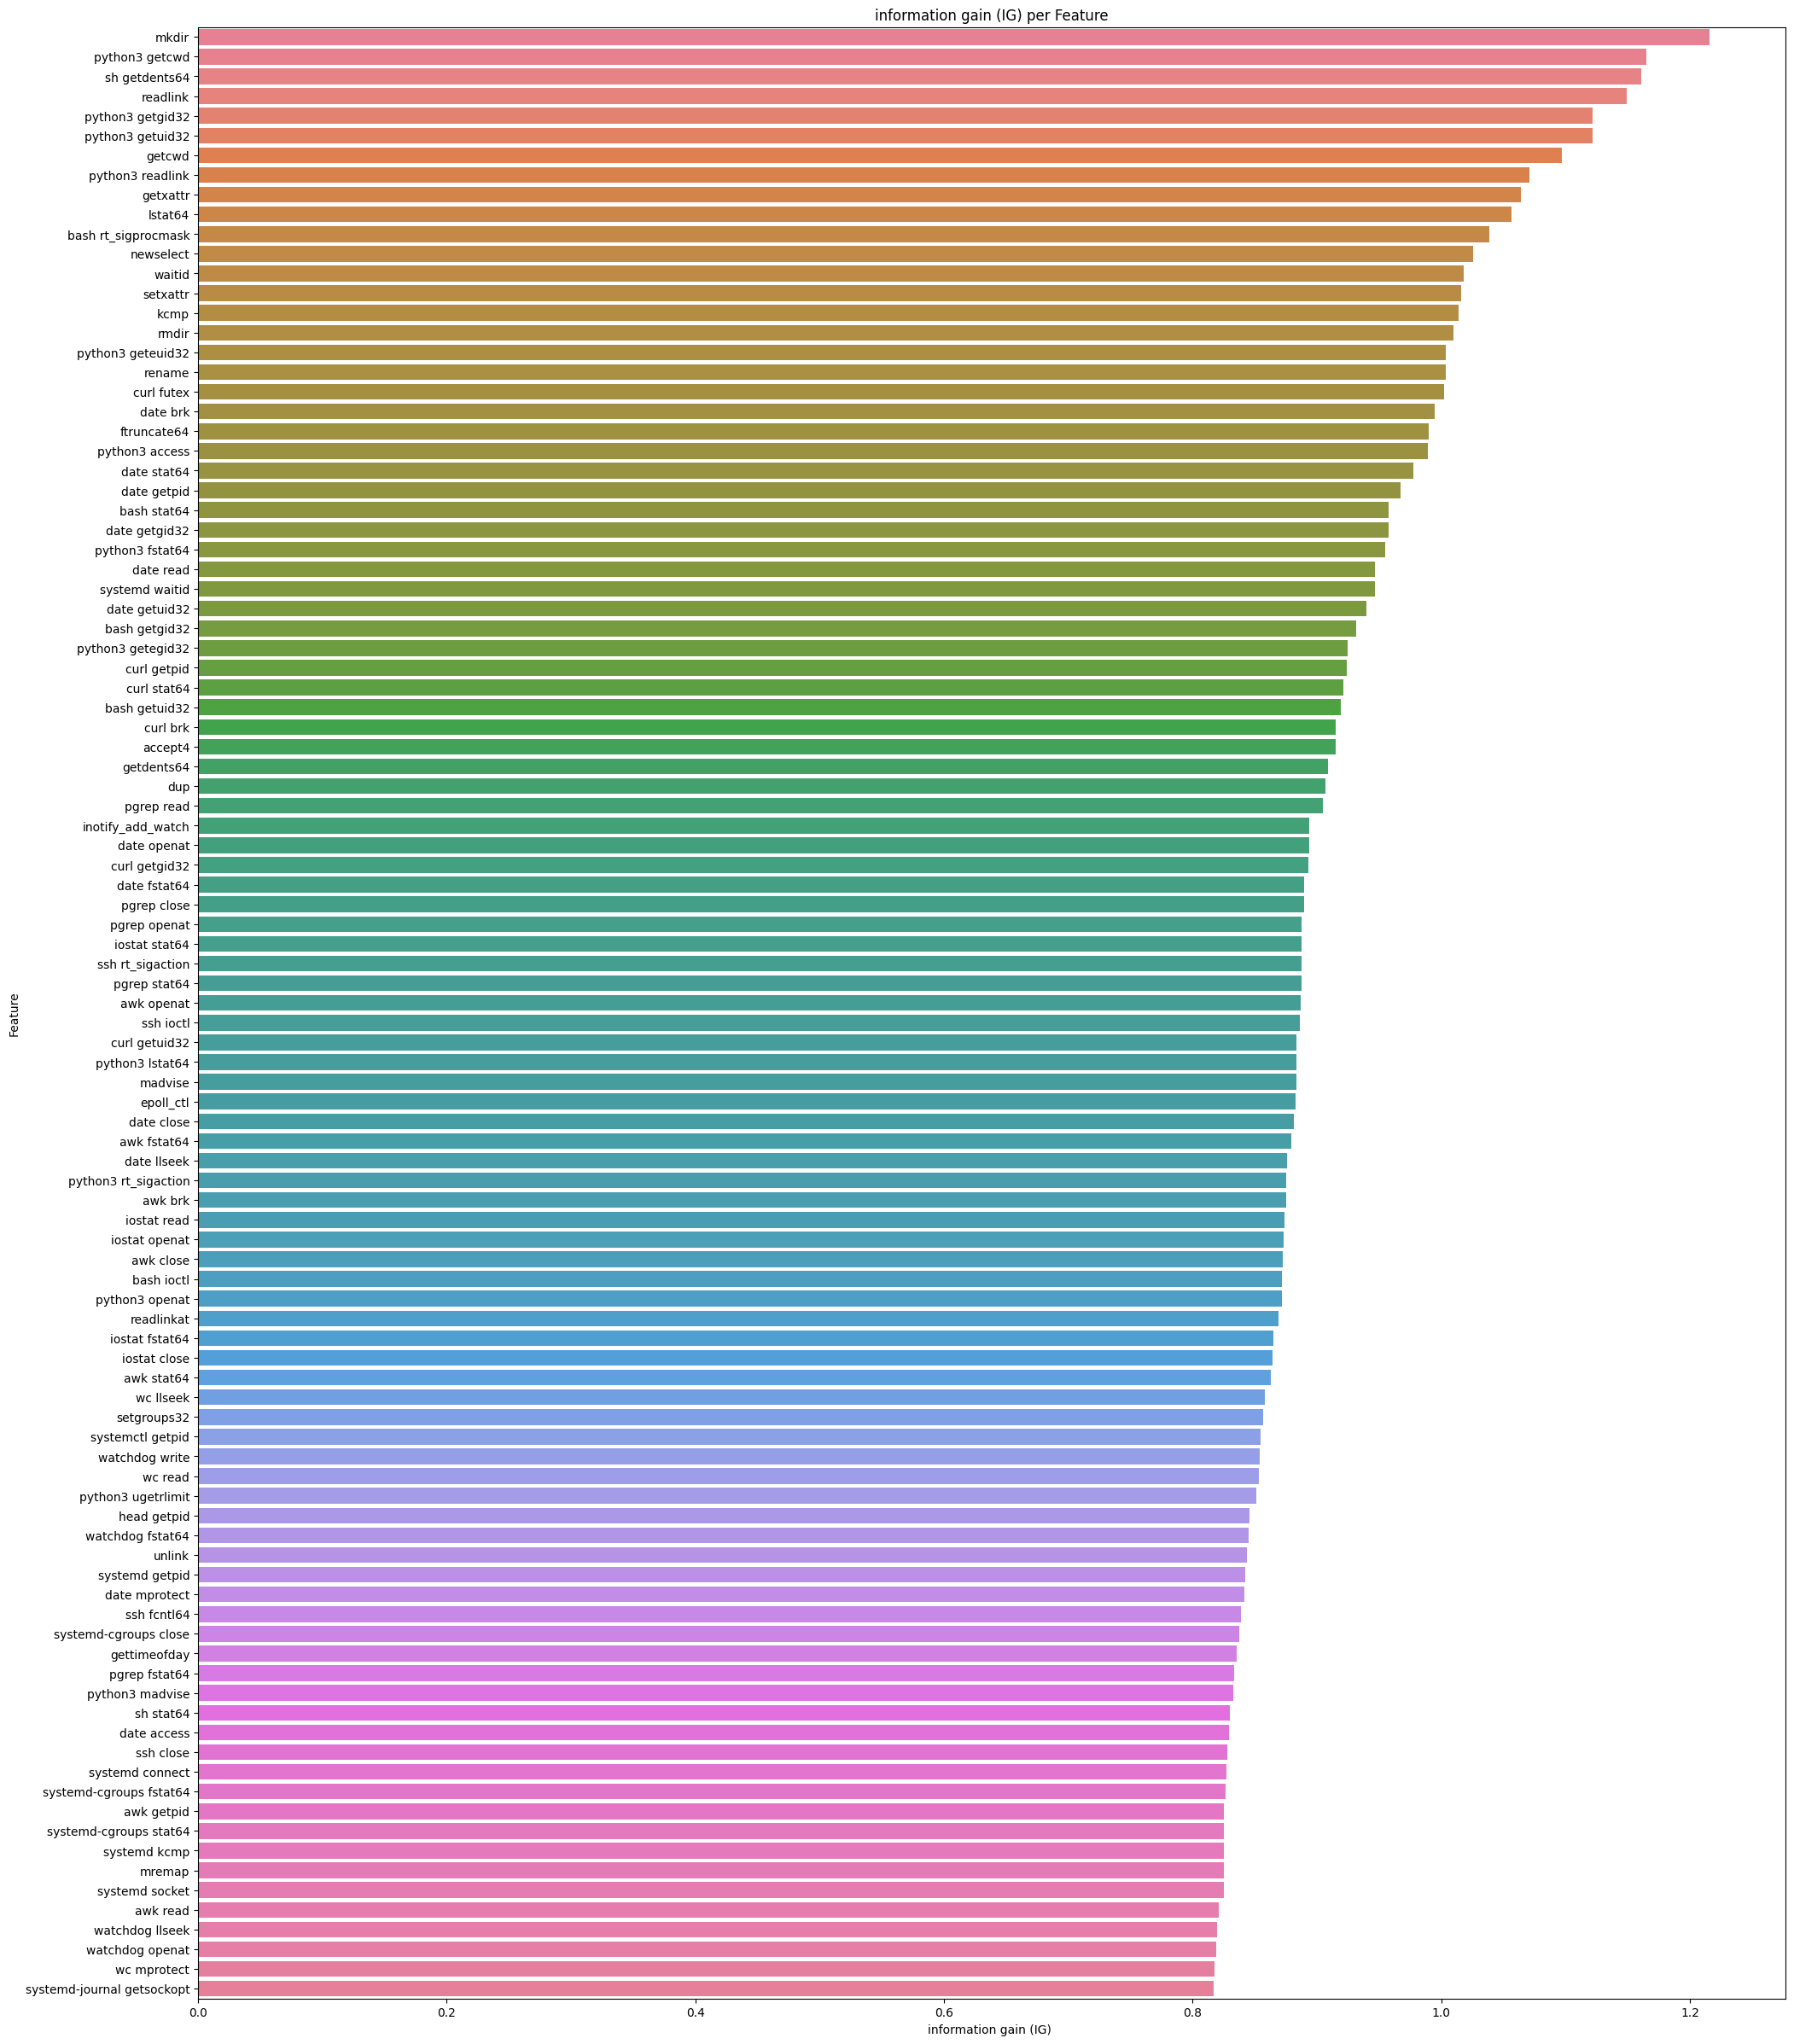

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

N =100

data_df = pd.DataFrame(result, columns=["Feature", "IG"])
data_df = data_df.sort_values(by="IG", ascending=False)
data_df = data_df.head(N)
plt.figure(figsize=(24, 30))
sns.barplot(data=data_df, native_scale=True, orient="h", hue="Feature", x="IG", y="Feature")

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('information gain (IG) ')

plt.title('information gain (IG) per Feature')
plt.show()

In [42]:
selected_cols = data_df["Feature"].values
selected_indices = np.where(np.isin(cols, selected_cols))[0]

In [44]:
ALL = hstack((X_tf[:, selected_indices], Z)).toarray()

cols = vectorizer.get_feature_names_out()
cols = cols[selected_indices]
cols = np.append(cols, [['timestamp'], ['label']])
print (cols.shape)
df = pd.DataFrame(ALL, columns=cols)

label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.inverse_transform(df['label'].values.astype(int))

(102,)


In [46]:
df.head(1)

accept4   awk brk  awk close  awk fstat64  awk getpid  awk openat  \
0  0.000004  0.000067    0.00018     0.000135    0.000023    0.000112   

   awk read  awk stat64  bash getgid32  bash getuid32  ...    waitid  \
0  0.000786    0.000205            0.0            0.0  ...  0.000002   

   watchdog fstat64  watchdog llseek  watchdog openat  watchdog write  \
0          0.000002         0.000002         0.000005        0.000017   

   wc llseek  wc mprotect  wc read     timestamp       label  
0   0.000056     0.000019  0.00007  1.699727e+09  7_backdoor  

[1 rows x 102 columns]

#### Plots

In [47]:
vectors = df.iloc[:, :-2]
# vectors_scaled = feature_plotting.minmax_scale_features(vectors,
#                                                         remove_outliers_iqr_all_columns=False,
#                                                         cols_to_exclude_from_scaling=[])

# df_scaled = vectors_scaled.copy()
# df_scaled['label'] = df['label']
# df_scaled['timestamp'] = df['timestamp']

###### Merged over Labels

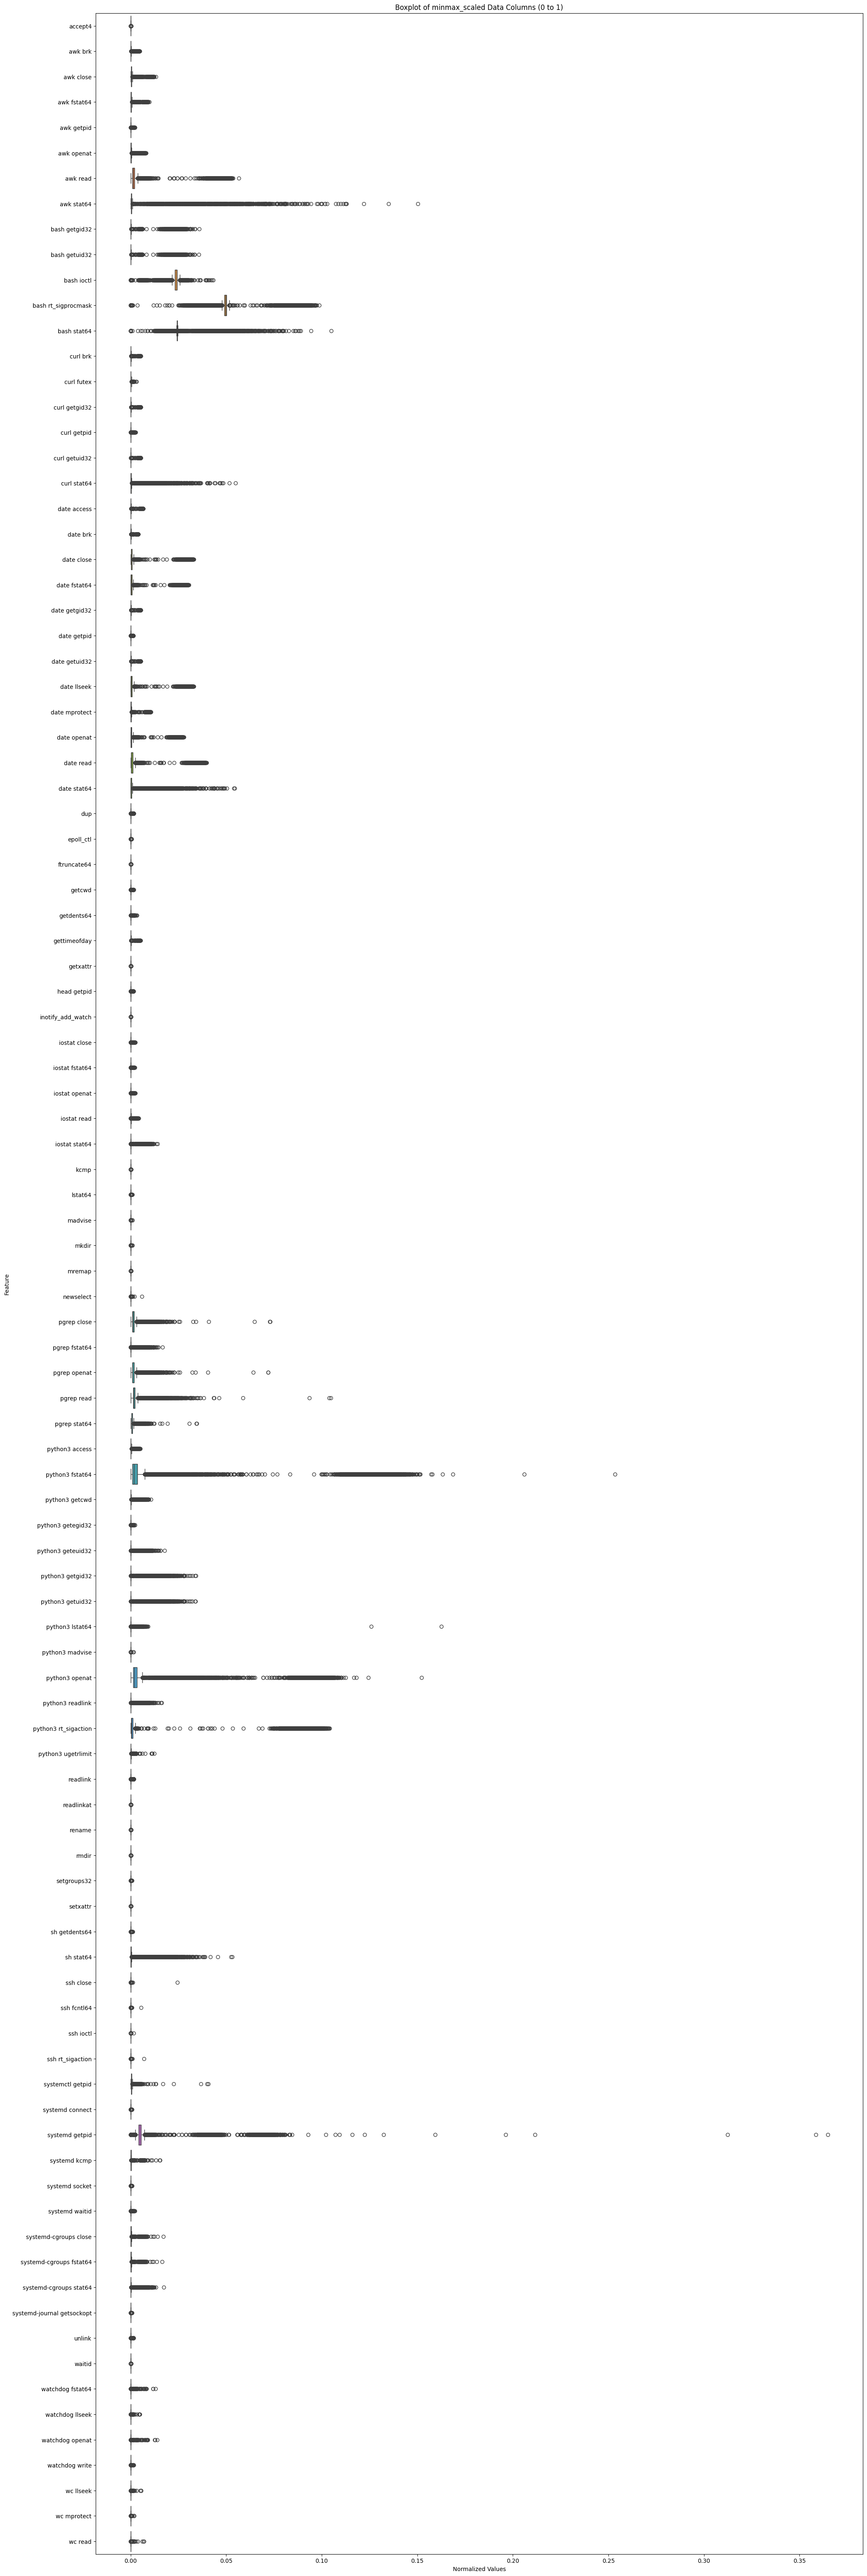

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 80))
sns.boxplot(data=vectors, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('Normalized Values')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1)')
plt.show()

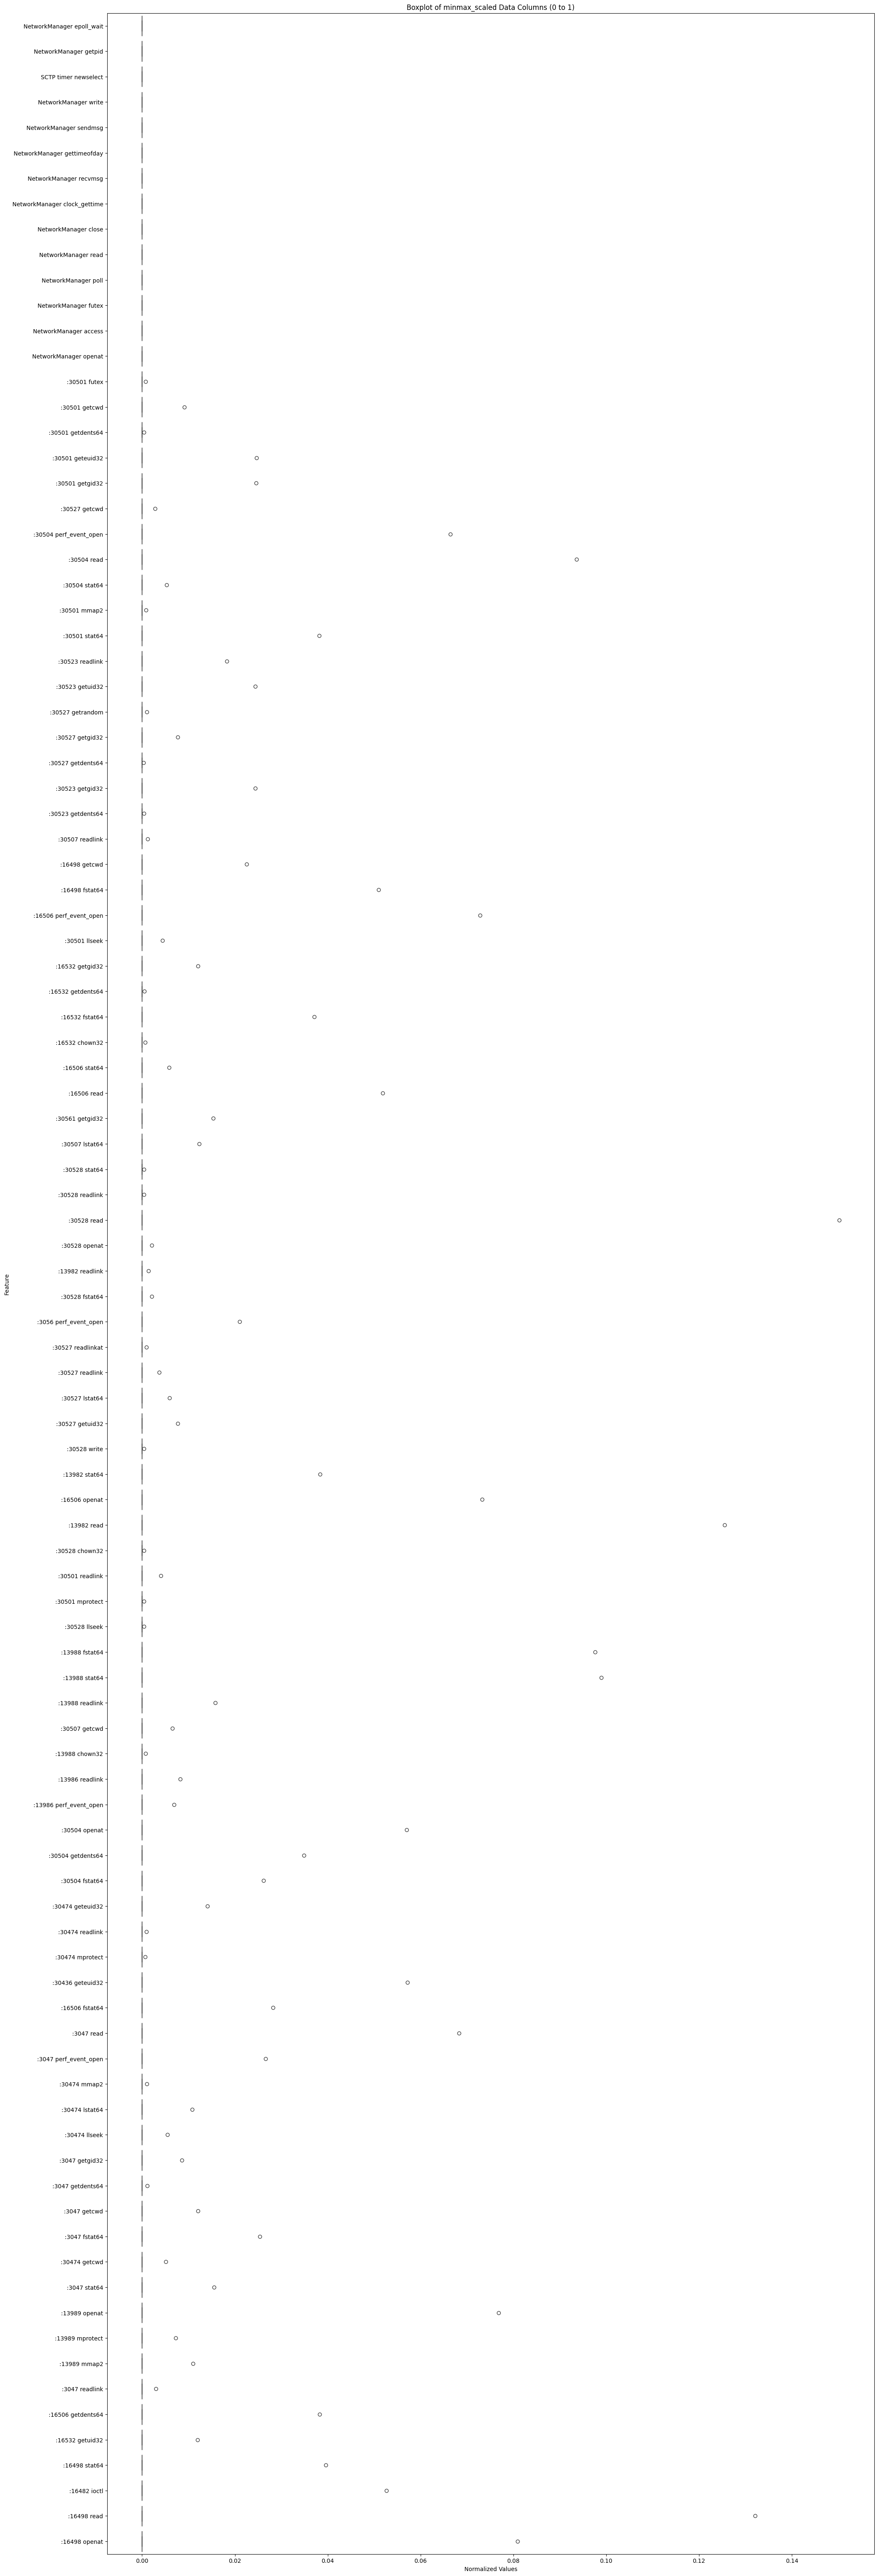

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 80))
sns.boxplot(data=vectors, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('Normalized Values')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1)')
plt.show()

In [17]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(24, 80))
# sns.boxplot(data=vectors_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

# plt.ylabel('Feature')
# # plt.xticks(rotation=45)
# plt.xlabel('Normalized Values')

# plt.title('Boxplot of minmax_scaled Data Columns (0 to 1)')
# plt.show()

##### Split into labels

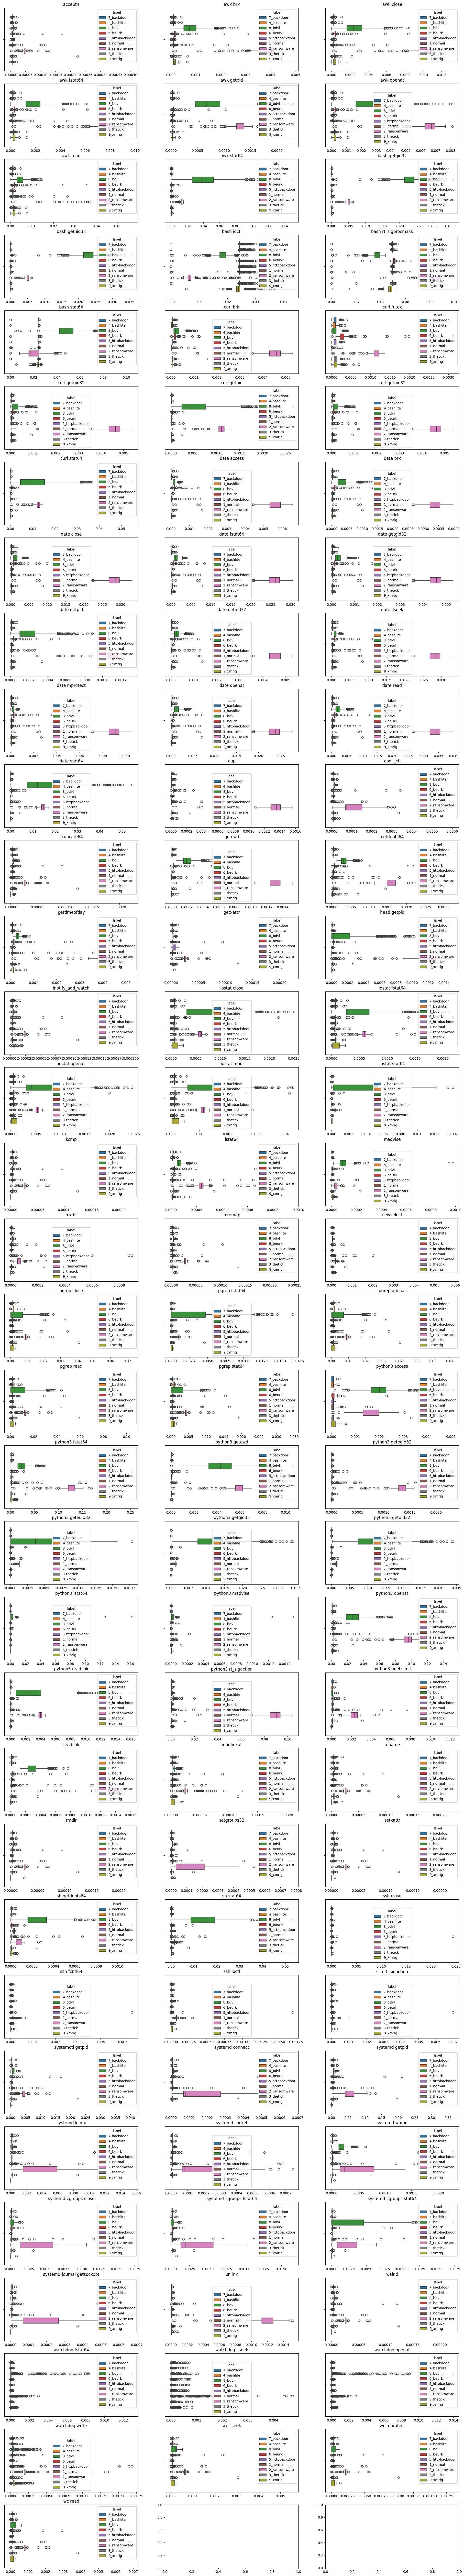

In [58]:


import seaborn as sns
import matplotlib.pyplot as plt

figcount_x = 3
figcount_y = (df.shape[1] + 2) // figcount_x
fig, axs = plt.subplots(figcount_y, figcount_x, figsize=(24, figcount_y * 4))

axs = axs.flatten()


for i, column in enumerate(df.columns):
    if column == "label" or column == "timestamp":
        continue

    sns.boxplot(data=df, x=column, ax=axs[i], hue="label", native_scale=True, orient="h",
                legend=True)
    axs[i].set_title(f'{column}')
    axs[i].set_xlabel('')

plt.show()

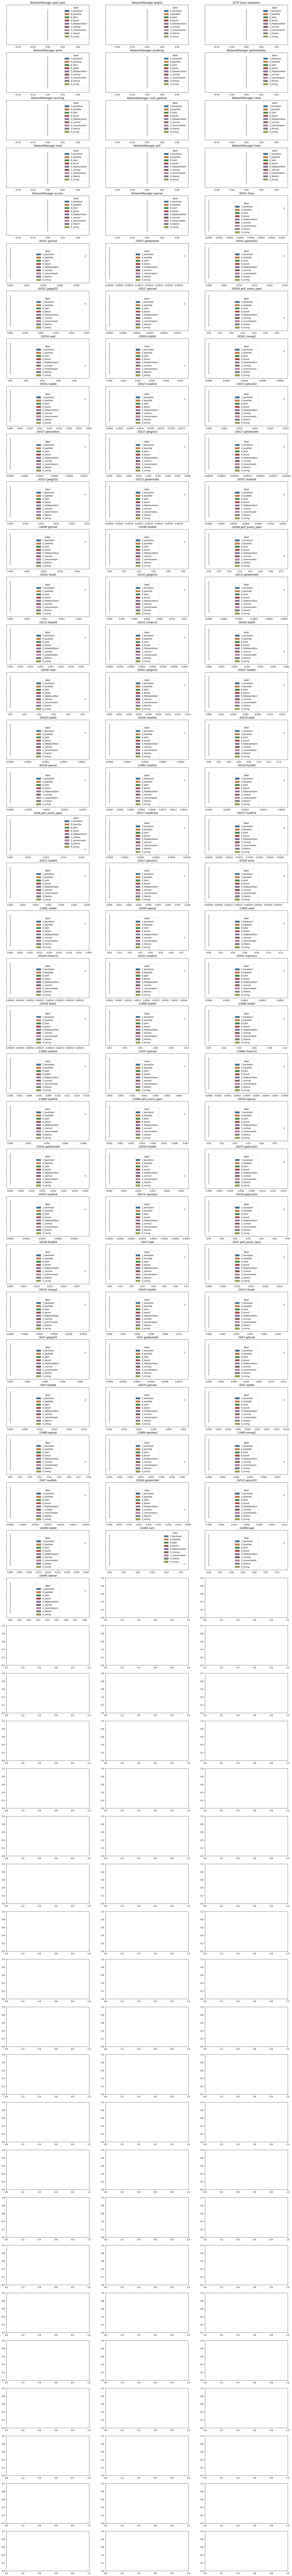

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(54, 3, figsize=(24, 220))

axs = axs.flatten()


for i, column in enumerate(df.columns):
    if column == "label" or column == "timestamp":
        continue

    sns.boxplot(data=df, x=column, ax=axs[i], hue="label", native_scale=True, orient="h",
                legend=True)
    axs[i].set_title(f'{column}')
    axs[i].set_xlabel('')

plt.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(54, 3, figsize=(24, 220))

# axs = axs.flatten()


# for i, column in enumerate(df_scaled.columns):
#     if column == "label" or column == "timestamp":
#         continue

#     sns.boxplot(data=df_scaled, x=column, ax=axs[i], hue="label", native_scale=True, orient="h",
#                 legend=True)
#     axs[i].set_title(f'{column}')
#     axs[i].set_xlabel('')

# plt.show()

### Testing PCA

In [11]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Initialize a list to store the explained variance ratios
explained_variance_ratios = []

# Perform PCA in several rounds, varying the number of components
for n_components in range(1, 11):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X[:, :-2])
    explained_variance_ratios.append(pca.explained_variance_ratio_.sum())

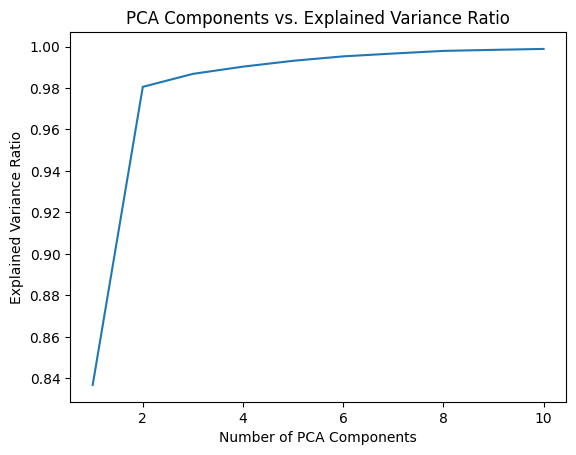

In [12]:
# Plot the explained variance ratios
plt.plot(range(1, 11), explained_variance_ratios)
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Components vs. Explained Variance Ratio')
plt.show()

In [13]:
print("The second component already explains ~0.9805749462367638% of the variance, which is an extremely high value and enough for here.")
explained_variance_ratios

The second component already explains ~0.9805749462367638% of the variance, which is an extremely high value and enough for here.


[0.8367923431073182,
 0.9805749462367628,
 0.9868319160776392,
 0.9903160949023201,
 0.993137124638921,
 0.9952757304358456,
 0.996647481118043,
 0.9979124438982031,
 0.9984167686318278,
 0.998865550790888]

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X[:, :-2])
print(pca.explained_variance_ratio_.sum())
X_pca.shape

0.9805749462367646


(11428, 2)

In [15]:
X_pca = np.column_stack((X_pca, X[:, -2:]))
X_pca.shape

(11428, 4)

In [16]:
df_pca = pd.DataFrame(X_pca, columns=['pca1','pca2', 'timestamp', 'label'])

label_encoder = sys_func.create_label_encoder_for_labels()
df_pca['label'] = label_encoder.inverse_transform(df_pca['label'].values.astype(int))

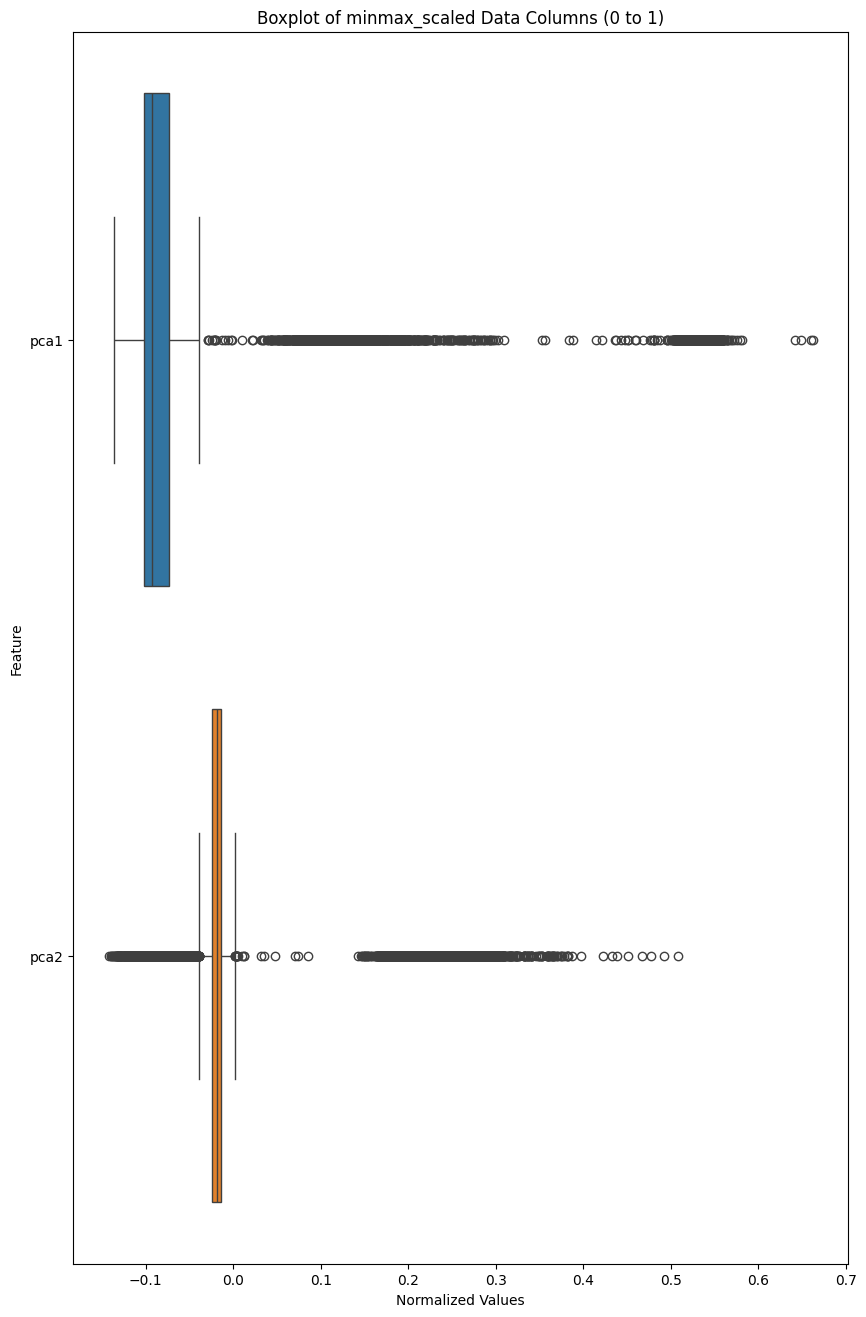

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 16))
sns.boxplot(data=df_pca.iloc[:, :-2], native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('Normalized Values')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1)')
plt.show()

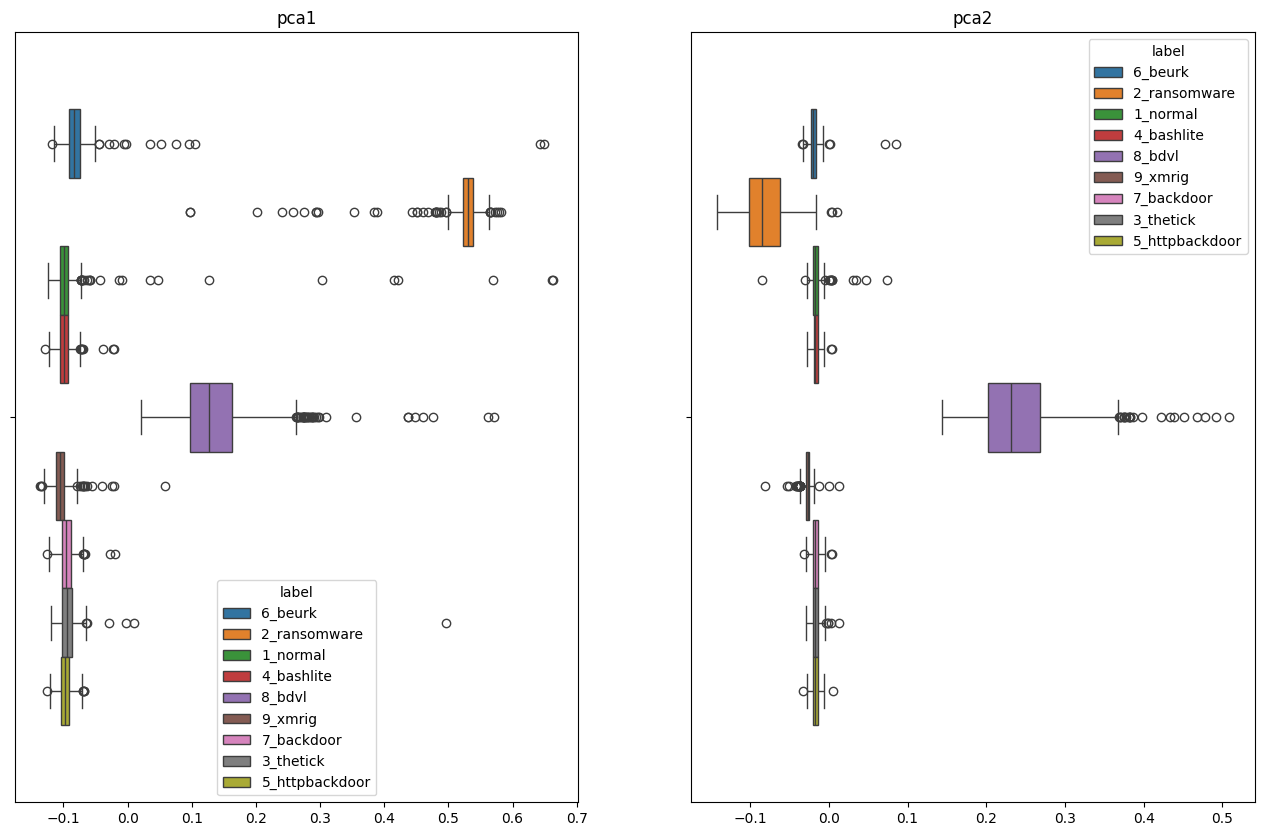

: 

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 10))

axs = axs.flatten()


for i, column in enumerate(df_pca.columns):
    if column == "label" or column == "timestamp":
        continue

    sns.boxplot(data=df_pca, x=column, ax=axs[i], hue="label", native_scale=True, orient="h",
                legend=True)
    axs[i].set_title(f'{column}')
    axs[i].set_xlabel('')

plt.show()